# Sina Weibo prediction

In [10]:
%pip install autograd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 703.5 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [40]:
import gc
import torch
#import cuml
import umap
import warnings
#TODO: import joblib
from jieba import analyse as jbanalyse
import numpy as np
import pandas as pd
import seaborn as sns
import functools as fn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import autograd.numpy as anp

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer
from numpy.typing import ArrayLike
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.multioutput import RegressorChain, ClassifierChain
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost.utils import get_gpu_device_count
from autograd import grad
from lightgbm import LGBMRegressor

RANDOM_STATE=8402
RNG=np.random.default_rng(seed=RANDOM_STATE)
CV_SPLITS=5
BATCH_SIZE=(256+64)*2 # for 2 gpu approx 12GB mem-usage each

warnings.filterwarnings("ignore", "use_inf_as_na")

def gpu_or_else(gpu, no_gpu):
    return gpu if torch.cuda.is_available() else no_gpu
print(gpu_or_else('GPU available', 'No GPU available using CPU'))

GPU available


Defining the loss function

In [12]:
def mixed_loss(y_true: ArrayLike, y_pred: ArrayLike, bias=[5,3,3], scaling=[.5,.25,.25], thresold=.8):
    precision = 1 - anp.sum((anp.abs(y_pred-y_true)/(y_true + bias)) * scaling, axis=1)
    sgn_precision = precision > thresold
    count_row_sum = anp.sum(anp.clip(y_true, a_min=None, a_max=100), axis=1) + 1
    return anp.sum(count_row_sum * sgn_precision) / anp.sum(count_row_sum)

def mixed_loss_objective(y_true, y_pred, weights, loss_f=mixed_loss):
    y_pred = anp.array(y_pred)
    y_true = anp.array(y_true)
    grad_loss = grad(loss_f, 1)
    gradients = grad_loss(y_true, y_pred)
    hessians = -anp.ones_like(gradients)

    if weights is not None:
        weights = anp.array(weights)
        gradients *= weights
        hessians *= weights

    return gradients, hessians
        

mixed_scorer = make_scorer(mixed_loss, greater_is_better=True)

## Dataset preperation

In [13]:
def file_to_df(filename, col_names=['uid', 'mid', 'ts', 'forward_n', 'comment_n', 'like_n', 'content']):
    """Helper to parse data. Contains hardcoded logic"""
    df = pd.read_csv(filename, sep='\t', names=col_names)
    if 'ts' in col_names:
        df['ts'] = pd.to_datetime(df['ts'])
    return df

In [14]:
Xy_tv = file_to_df('/kaggle/input/sna-weibo-data/Weibo Data/weibo_train_data(new)/weibo_train_data.txt')
X_tv = Xy_tv.drop(['forward_n', 'comment_n', 'like_n'], axis=1)
y_tv = Xy_tv[['forward_n', 'comment_n', 'like_n']].replace([np.inf, -np.inf], np.nan)

In [34]:
Xy_tv.shape, X_tv.shape, y_tv.shape

((1225088, 7), (1225088, 4), (1225088, 3))

In [15]:
X_tv.head()

,uid,mid,ts,content
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,2015-02-23 17:41:29,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...
1,fa13974743d3fe6ff40d21b872325e9e,8169f1d45051e08ef213bf1106b1225d,2015-02-14 12:49:58,#丁辰灵的红包#挣钱是一种能力，抢红包拼的是技术。我抢到了丁辰灵 和@阚洪岩 一起发出的现金...
2,da534fe87e7a52777bee5c30573ed5fd,68cd0258c31c2c525f94febea2d9523b,2015-03-31 13:58:06,淘宝网这些傻逼。。。气的劳资有火没地儿发~尼玛，你们都瞎了
3,e06a22b7e065e559a1f0bf7841a85c51,00b9f86b4915aedb7db943c54fd19d59,2015-06-11 20:39:57,看点不能说的，你们都懂[笑cry]
4,f9828598f9664d4e347ef2048ce17734,c7f6f66044c0c5a3330e2c5371be6824,2015-03-10 18:02:38,111多张


In [16]:
y_tv.head()

,forward_n,comment_n,like_n
0,0,0,0
1,0,0,0
2,0,0,0
3,0,4,3
4,0,0,0


## Data analysis

### Navive analysis

In [17]:
def embedd(
    data,
    vectorizer=TfidfVectorizer(stop_words='english', max_features=512),
    reducer=gpu_or_else(
        umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2),# TODO maybe enable GPU: cuml.UMAP(n_neighbors=10, min_dist=0.3, n_components=2),
        umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2),
    )
):
    embeddings = vectorizer.fit_transform(data)
    return reducer.fit_transform(embeddings)

def plot_embeddings(embeddings, y):
    categories = np.sum(y * [.5, .25, .25], axis=1)
    alhpa_vals = np.log10(categories / categories.max() + 0.01) / np.log10(1.01)
    scaled_alpha_vals = np.clip((alhpa_vals - alhpa_vals.min()) / (alhpa_vals.max() - alhpa_vals.min()), a_min=None, a_max=1)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        c=categories,
        cmap='Spectral',
        s=5,
        alpha=scaled_alpha_vals
    )
    plt.colorbar(scatter)
    plt.title('Projection of Text Embeddings', fontsize=18)
    plt.xlabel('dim 1', fontsize=14)
    plt.ylabel('dim 2', fontsize=14)
    plt.grid(True)
    plt.show()

### Naive Embeddings

In [ ]:
plot_embeddings(
    embedd(X_tv.content.sample(100_000, random_state=RANDOM_STATE)),
    y_tv.sample(100_000, random_state=RANDOM_STATE)
)

### Jieba embeddings

In [ ]:
plot_embeddings(
    embedd(
        X_tv.content.sample(100_000, random_state=RANDOM_STATE),
        vectorizer=TfidfVectorizer(analyzer=fn.partial(jbanalyse.extract_tags), max_features=512),
    ),
    y_tv.sample(100_000, random_state=RANDOM_STATE),
)

### Huggingface embeddings

In [ ]:
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx].clone().detach() for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

class ChineseBertVectorizer():
    def __init__(
        self,
        device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
        batch_size=1024,
        verbose=0
    ):
        self.tokenizer = AutoTokenizer.from_pretrained(
            "google-bert/bert-base-chinese", 
            padding=True,
            truncation=True
        )
        self.model = AutoModel.from_pretrained("google-bert/bert-base-chinese")
        self.device = device
        self.batch_size=batch_size
        self.verbose=verbose
    
    def fit_transform(self, data, batch_size=None, verbose=None):
        if not isinstance(data, list):
            data = data.tolist()
        if not batch_size:
            batch_size = self.batch_size
        if not verbose:
            verbose = self.verbose
        
        try:
            return self.get_embeddings(data, batch_size=batch_size, verbose=verbose)
        finally:
            if verbose:
                print('cleaning up...')
            if verbose > 1:
                print(torch.cuda.memory_summary())
            gc.collect()
            torch.cuda.empty_cache()
            if verbose:
                print('done cleaning')
            if verbose > 1:
                print(torch.cuda.memory_summary())


    def get_embeddings(self, data, batch_size, verbose=0):
        if verbose:
            print('tokenizing...')
        encoded_input = self.tokenizer(
            data, padding=True, truncation=True, return_tensors='pt'
        )
        dataset = TextDataset(encoded_input)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        embeddings = []
        embedder = nn.DataParallel(self.model)
        embedder = embedder.to(self.device)
        for batch in tqdm(loader, disable=verbose<1, desc='embedding', unit='batch'):
            batch_ = {k: v.to(self.device) for k, v in batch.items()}
            with torch.no_grad():
                if verbose>1:
                    print(torch.cuda.memory_summary())
                    
                outputs = embedder(**batch_)
                if self.device.type == 'cuda':
                    batch_embeddings = outputs.last_hidden_state[:, 0, :]
                    embeddings.append(batch_embeddings.cpu())
                    for v in batch_.values():
                             del v
                    del batch_
                    del outputs
                    gc.collect()
                    torch.cuda.empty_cache()
                else:
                    batch_embeddings = outputs.last_hidden_state[:, 0, :]
                    embeddings.append(batch_embeddings.cpu())
        
        if self.device.type == 'cuda':
            del embedder
            gc.collect()
            torch.cuda.empty_cache()

        embeddings = torch.cat(embeddings, dim=0)
        if verbose:
            print('embeddings done')

        return embeddings

In [ ]:
plot_embeddings(
    embedd(
        X_tv.content.sample(100_000, random_state=RANDOM_STATE),
        vectorizer=ChineseBertVectorizer(batch_size=BATCH_SIZE, verbose=1)
    ),
    y_tv.sample(100_000, random_state=RANDOM_STATE)
)

### Target analysis

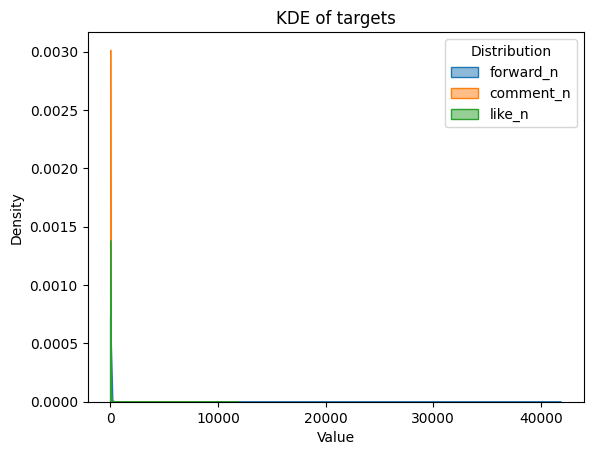

In [7]:
for column in y_tv.columns:
    sns.kdeplot(y_tv[column], label=column, fill=True, common_norm=False, alpha=0.5)

plt.title('KDE of targets')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(title='Distribution')

Let's log scale it to make it more gaussian

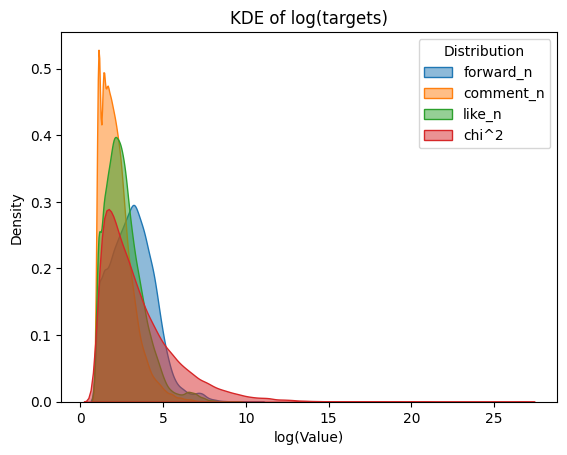

In [8]:
y_tv_no_low = y_tv[np.all(y_tv > 2, axis=1)]
for column in y_tv.columns:
    sns.kdeplot(np.log(y_tv_no_low[column]), label=column, fill=True, common_norm=False, alpha=0.5)
    
sns.kdeplot(RNG.chisquare(2.5,size=y_tv_no_low.shape[0])+1, label='chi^2', fill=True, common_norm=False, alpha=0.5)

plt.title('KDE of log(targets)')
plt.xlabel('log(Value)')
plt.ylabel('Density')
plt.legend(title='Distribution')

### User segementation

In [9]:
TOP_K_UID=10

In [10]:
user_segementation_df = X_tv[['uid']]
user_segementation_df.loc[: ,['forward_n', 'comment_n', 'like_n']] = y_tv
user_segementation_df.loc[: ,['popularity']] = (y_tv * [.5, .25, .25]).sum(axis=1)

In [30]:
np.unique(user_segementation_df[user_segementation_df.popularity > 10].uid).shape

(2449,)

In [11]:
user_segementation_df.loc[:, ['median_popularity']] = user_segementation_df['uid'].map(user_segementation_df.groupby('uid')['popularity'].median())
user_segementation_df.loc[:, ['mean_popularity']] = user_segementation_df['uid'].map(user_segementation_df.groupby('uid')['popularity'].mean())

In [12]:
user_segementation_df.head()

,uid,forward_n,comment_n,like_n,popularity,median_popularity,mean_popularity
0,d38e9bed5d98110dc2489d0d1cac3c2a,0,0,0,0.00,0.0,0.627724
1,fa13974743d3fe6ff40d21b872325e9e,0,0,0,0.00,0.0,0.233083
2,da534fe87e7a52777bee5c30573ed5fd,0,0,0,0.00,0.0,0.107143
3,e06a22b7e065e559a1f0bf7841a85c51,0,4,3,1.75,1.5,3.276644
4,f9828598f9664d4e347ef2048ce17734,0,0,0,0.00,0.0,0.132075


In [13]:
top_uids = user_segementation_df.groupby('uid')['popularity'].sum().sort_values(ascending=False)[:TOP_K_UID].index
top_k_uid_df = user_segementation_df[user_segementation_df['uid'].isin(top_uids)]
top_k_uid_df.shape

(10565, 7)

In [20]:
top_k_uid_df.sort_values('popularity', ascending=False).head()

,uid,forward_n,comment_n,like_n,popularity,median_popularity,mean_popularity
960724,42fffa7b95d37f3d414114974772d14f,41850,1767,11697,24291.00,38.5,158.580508
21949,e88330514585dc40b7cb8f48c0e0ea2a,19255,7231,1557,11824.50,661.0,769.311528
1033865,8507f224ff141fcdc92d6cca325a948a,20954,4266,33,11551.75,7.0,134.566787
1135986,e88330514585dc40b7cb8f48c0e0ea2a,18609,837,6304,11089.75,661.0,769.311528
594288,e88330514585dc40b7cb8f48c0e0ea2a,14796,5075,1007,8918.50,661.0,769.311528


In [15]:
no0_top_k_uid_df = top_k_uid_df.astype({k: float for k in ['forward_n','comment_n','like_n','popularity','median_popularity', 'mean_popularity']})
no0_top_k_uid_df.loc[:,['forward_n','comment_n','like_n','popularity','median_popularity', 'mean_popularity']] = no0_top_k_uid_df[['forward_n','comment_n','like_n','popularity','median_popularity', 'mean_popularity']] +.0001

/tmp/ipykernel_33/2717652779.py:16: RuntimeWarning: overflow encountered in exp
  return f"{np.exp(x):.2f}"


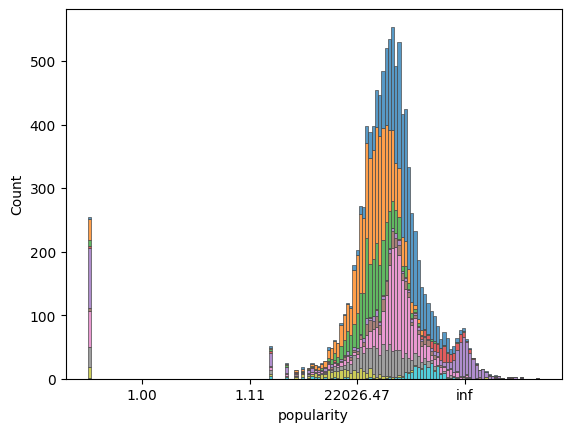

In [16]:
warnings.filterwarnings('ignore', category=FutureWarning)
ax = sns.histplot(
    no0_top_k_uid_df,
    x='popularity', hue='uid',
    multiple='stack',
    #palette='light:m_r',
    edgecolor='.3',
    linewidth=.5,
    log_scale=True,
    legend=False,
)

def exp_formatter(x, pos):
    """Converts log scale labels back to the exponential scale"""
    return f"{np.exp(x):.2f}"

ax.get_xaxis().set_major_formatter(mtick.FuncFormatter(exp_formatter))
warnings.simplefilter('default', category=FutureWarning)

In [ ]:
%%script echo 'skip for now'
pal = sns.color_palette(palette='coolwarm', n_colors=TOP_K_UID)

g = sns.FacetGrid(top_k_uid_df, row='uid', hue='median_popularity', aspect=15, height=.75, palette=pal)

g.map(sns.boxplot, y='popularity', clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.boxplot, y='popularity', clip_on=False, 
      color="w", lw=2)

#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

#for i, ax in enumerate(g.axes.flat):
#    ax.text(0, 0, top_uids[i],
#            fontweight='bold', fontsize=7,
#            color=ax.lines[-1].get_color(),
#            ha='left', va='center')

g.fig.subplots_adjust(hspace=1)#-.3)

g.set_titles('')
g.set(yticks=[], ylabel='')
g.despine(bottom=True, left=True)

ax = g.axes.flat[-1]
plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
plt.xlabel('Popularity (forwards, comments and likes combined)', fontweight='bold', fontsize=15)
_ = g.fig.suptitle(f'Post potpularity of top {TOP_K_UID} users',
               ha='right',
               fontsize=20,
               fontweight=20)

## Model definition

### Transformer definitions

In [36]:
class TfIdfSingleThreadTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tf_idf = TfidfVectorizer(analyzer=jbanalyse.extract_tags, max_features=512)#tf_idf

    def fit(self, X, y=None):
        self.tf_idf = self.tf_idf.fit(X.iloc[:, 0])
        return self

    def transform(self, X: pd.DataFrame, y=None):
        X_trans = pd.DataFrame.sparse.from_spmatrix(
            self.tf_idf.transform(X.iloc[:, 0]),
            columns=self.tf_idf.get_feature_names_out()
        )
        return X_trans
    
    def get_feature_names_out(self, names=None):
        return self.tf_idf.get_feature_names_out(names)



class DateTimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, datetime_col='ts', expand=['hour', 'minute'], drop=True):
        self.datetime_col = datetime_col
        self.expand = expand
        self.drop = drop

    def fit(self, X, y=None):
        self.datetime_col_loc = X.columns.get_loc(self.datetime_col)
        return self

    def transform(self, X: pd.DataFrame, y=None):
        X_transformed = pd.DataFrame(X)
        X_transformed[self.datetime_col] = pd.to_datetime(X.iloc[:, self.datetime_col_loc])
        if 'hour' in self.expand:
            X_transformed['hour'] = X.iloc[:, self.datetime_col_loc].dt.hour
        if 'minute' in self.expand:
            X_transformed['minute'] = X.iloc[:, self.datetime_col_loc].dt.minute
        if 'second' in self.expand:
            X_transformed['second'] = X.iloc[:, self.datetime_col_loc].dt.second
        if self.drop:
            X_transformed = X_transformed.drop(X_transformed. columns[self.datetime_col_loc], axis=1)
        return X_transformed


class PopularityTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        classifier=ClassifierChain(
                CatBoostClassifier(
                    iterations=2000,
                    task_type=gpu_or_else('GPU', 'CPU'),
                    devices=list(range(get_gpu_device_count())),
                    boosting_type='Plain',
                    verbose=False,
                )
        ),
        get_classes=lambda y: next(
            (l for t, l in [
                (1, 0),
                (6, 5),
                (101, 100),
                (1_001, 1_000),
                (10_001, 10_000)
            ] if y <= t),
            10_001
        )
    ):
        self.classifier = classifier
        self.get_classes = np.vectorize(get_classes)

    def fit(self, X, y=None):
        y_ = self.get_classes(y)
        self.classifier = self.classifier.fit(X, y_)
        return self

    def transform(self, X: pd.DataFrame, y=None):
        X[[str(i) for i in self.classifier.classes_]] = self.classifier.predict_proba(X)
        return X
    
class OutputRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        model,
        transformation=lambda x: np.where(np.round(x)<=1, 0, np.round(x))
    ):
        self.model = model
        self.transformation = transformation

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        predictions = self.model.predict(X)
        return self.transformation(predictions)

In [19]:
%%script echo 'TODO fix'
p = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), make_column_selector(pattern='uid'))
    ),
    PopularityTransformer()#TODO: fix probability prediction
).fit(X_tmp, y_tmp)

TODO fix


In [20]:
%%script echo 'TODO fix'
p.steps[1][1].classifier.predict(X_tmp)

TODO fix


### Userid Model

In [30]:
def get_user_id_model(outputkwargs={}, catkwargs={}):
    return make_pipeline(
        make_column_transformer(
            (OneHotEncoder(handle_unknown='ignore'), make_column_selector(pattern='uid'))
        ),
        RegressorChain(
            OutputRegressor(
                CatBoostRegressor(
                    task_type=gpu_or_else('GPU', 'CPU'),
                    devices=list(range(get_gpu_device_count())),
                    boosting_type='Plain',
                    has_time=True,
                    verbose=False,
                    **catkwargs,
                ),
                **outputkwargs,
            ),
            verbose=False
        )
    )

### Catboost all features

In [31]:
def get_cat_all_features_model(outputkwargs={}, catkwargs={}): 
    return make_pipeline(
        DateTimeTransformer(datetime_col='ts', expand=['hour', 'minute', 'second'], drop=True),
        make_column_transformer(
            (OneHotEncoder(handle_unknown='ignore'),['uid', 'mid']),
            ('passthrough',['hour', 'minute', 'second']),
            (TfIdfSingleThreadTransformer(),['content']),
        ),
        RegressorChain(
            OutputRegressor(
                CatBoostRegressor(
                    task_type=gpu_or_else('GPU', 'CPU'),
                    devices=list(range(get_gpu_device_count())),
                    boosting_type='Plain',
                    has_time=True,
                    verbose=False,
                    **catkwargs,
                ),
                **outputkwargs
            ),
            verbose=False
        )
    )

### ItemCF model

In [23]:
%%script echo '#TODO skip for now'
class ItemCF:
    def __init__(self, data):
        self.data = data

    def user_item(self):  # Training set converted to dict
        data = self.data
        self.traindata = {}
        for user, item, time in np.array(data).tolist():
            self.traindata.setdefault(user, {})
            self.traindata[user][item] = 1  # time

    def ItemSimilarity(self, alpha=1):
        train = self.traindata
        # calculate co-rated users between items
        C = dict()
        N = dict()
        for u, items in train.items():
            for i, tui in items.items():
                N.setdefault(i, 0)
                N[i] += 1
                for j, tuj in items.items():
                    C.setdefault(i, {})
                    if i == j:
                        continue
                    C[i].setdefault(j, 0)
                    C[i][j] += 1 / (1 + alpha * abs(tui - tuj))
        # calculate finial similarity matrix W
        W = dict()
        for i, related_items in C.items():
            W.setdefault(i, {})
            for j, cij in related_items.items():
                W[i].setdefault(j, 0)
                W[i][j] = cij / math.sqrt(N[i] * N[j] * 1.0)
        self.itemSim = W

    def recommend(self, user, tid=1, k=1, beta=1):
        W = self.itemSim
        train = self.traindata
        rank = dict()
        ru = train.get(user, {})
        for i, tui in ru.items():
            for j, wj in W[i].items():
                if j in ru.keys():
                    continue
                rank.setdefault(j, 0)
                rank[j] += wj / (1 + beta * abs(tid - tui))
        return dict(sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:k])



class cWeibo:

    def __init__(self, path):
        self.path = path

    def importData(self):
        path = self.path
        # import sample set
        data = pd.read_csv(path,
                           encoding='utf8', sep='\t',
                           names=['luid', 'mid', 'time', 'fcs', 'ccs', 'lcs', 'cont'])  # nrows=1000
        data['fcs'] = data['fcs'].astype('int')  # one week after repost，weight 0.5
        data['ccs'] = data['ccs'].astype('int')  # one week after comments,  0.25
        data['lcs'] = data['lcs'].astype('int')  # one week after likes 0.25
        train, test = model_selection.train_test_split(data, test_size=0.2)
        self.traindata = pd.DataFrame(data)  # train set
        self.testdata = pd.DataFrame(test)  # test set

        data = pd.read_csv(
            path,
            encoding='utf8', sep='\t', names=['luid', 'mid', 'time', 'cont'])  # nrows=100
        self.predata = data  # predict set

    def ETL(self):

        # Convert time to 0-23 numbers, taking into account special holidays if necessary.
        self.traindata['time'] = self.traindata.apply(lambda x: (time.strptime(x['time'], "%Y-%m-%d %H:%M:%S")).tm_hour,
                                                      axis=1)
        self.traindata.rename(columns=lambda x: x.replace('time', 'tid'), inplace=True)  # rename tid
        self.testdata['time'] = self.testdata.apply(lambda x: (time.strptime(x['time'], "%Y-%m-%d %H:%M:%S")).tm_hour,
                                                    axis=1)
        self.testdata.rename(columns=lambda x: x.replace('time', 'tid'), inplace=True)
        self.predata['time'] = self.predata.apply(lambda x: (time.strptime(x['time'], "%Y-%m-%d %H:%M:%S")).tm_hour,
                                                  axis=1)
        self.predata.rename(columns=lambda x: x.replace('time', 'tid'), inplace=True)
        # content analysis , consider special meaning words likes red poket
        # jieba.suggest_freq('@', True)
        self.traindata['cont'] = self.traindata['cont'].astype(str).fillna('')
        self.traindata['cont'] = self.traindata.apply(lambda x: ",".join(jieba.analyse.extract_tags(x['cont'], topK=50, \
                                                                                                    allowPOS=(
                                                                                                    'n', 'nr', 'ns',
                                                                                                    'nt', 'nz', 'a',
                                                                                                    'ad', 'an', 'f',
                                                                                                    's', 'i', 't', 'v',
                                                                                                    'vd', 'vn'))),
                                                      axis=1)
        self.traindata = self.traindata.drop('cont', axis=1).join(
            self.traindata['cont'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('tag'))

        self.testdata['cont'] = self.testdata['cont'].astype(str).fillna('')
        self.testdata['cont'] = self.testdata.apply(lambda x: ",".join(jieba.analyse.extract_tags(x['cont'], topK=50, \
                                                                                                  allowPOS=(
                                                                                                  'n', 'nr', 'ns', 'nt',
                                                                                                  'nz', 'a', 'ad', 'an',
                                                                                                  'f', 's', 'i', 't',
                                                                                                  'v', 'vd', 'vn'))),
                                                    axis=1)
        self.testdata = self.testdata.drop('cont', axis=1).join(
            self.testdata['cont'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('tag'))

        self.predata['cont'] = self.predata['cont'].astype(str).fillna('')
        self.predata['cont'] = self.predata.apply(lambda x: ",".join(jieba.analyse.extract_tags(x['cont'], topK=50, \
                                                                                                allowPOS=(
                                                                                                'n', 'nr', 'ns', 'nt',
                                                                                                'nz', 'a', 'ad', 'an',
                                                                                                'f', 's', 'i', 't', 'v',
                                                                                                'vd', 'vn'))), axis=1)
        self.predata = self.predata.drop('cont', axis=1).join(
            self.predata['cont'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('tag'))
        # Create indexing
        ft_train = set(self.traindata.iloc[:, 6])
        ft_pred = set(self.predata.iloc[:, 3])
        ft = list(ft_train.symmetric_difference(ft_pred))
        df_ft = pd.DataFrame(ft, columns=['tag'])
        df_ft['fid'] = df_ft.index
        self.traindata = pd.merge(self.traindata, df_ft, on=['tag'], how='left')
        self.traindata = self.traindata[['luid', 'mid', 'tid', 'fid', 'fcs', 'ccs', 'lcs']]
        self.traindata = self.traindata.dropna(axis=0, how='any')
        self.traindata['fid'] = self.traindata['fid'].astype('int')
        print(self.traindata.shape)
        self.testdata = pd.merge(self.testdata, df_ft, on=['tag'], how='left')
        self.testdata = self.testdata[['luid', 'mid', 'tid', 'fid', 'fcs', 'ccs', 'lcs']]
        self.testdata = self.testdata.dropna(axis=0, how='any')
        self.testdata['fid'] = self.testdata['fid'].astype('int')
        print(self.testdata.shape)
        self.predata = pd.merge(self.predata, df_ft, on=['tag'], how='left')
        self.predata = self.predata[['luid', 'mid', 'tid', 'fid']]
        self.predata = self.predata.dropna(axis=0, how='any')
        self.predata['fid'] = self.predata['fid'].astype('int')
        print(self.predata.shape)

    def callItemCF(self):
        data = self.traindata

        data_f = data[['fid', 'fcs', 'tid']]
        data_c = data[['fid', 'ccs', 'tid']]
        data_l = data[['fid', 'lcs', 'tid']]
        # Training the Retweet Count Recommendation Model
        ic_f = ItemCF(data_f)
        ic_f.user_item()  # Transform into dict and generate training and test sets
        ic_f.ItemSimilarity()  # Generate item similarity matrix
        self.ic_f = ic_f

        ic_c = ItemCF(data_c)
        ic_c.user_item()
        ic_c.ItemSimilarity()
        self.ic_c = ic_c

        ic_l = ItemCF(data_l)
        ic_l.user_item()
        ic_l.ItemSimilarity()
        self.ic_l = ic_l

        test = self.testdata
        test_f = test[['mid', 'fid', 'tid', 'fcs']]
        test_c = test[['mid', 'fid', 'tid', 'ccs']]
        test_l = test[['mid', 'fid', 'tid', 'lcs']]
        test_f['pfcs'] = test_f.apply(
            lambda x: list(ic_f.recommend(x['fid']).keys())[0] if ic_f.recommend(x['fid']) else 0, axis=1)

        test_c['pccs'] = test_c.apply(
            lambda x: list(ic_c.recommend(x['fid']).keys())[0] if ic_c.recommend(x['fid']) else 0, axis=1)

        test_l['plcs'] = test_l.apply(
            lambda x: list(ic_l.recommend(x['fid']).keys())[0] if ic_l.recommend(x['fid']) else 0, axis=1)

        # 计算准确率
        precision = self.precision(test_f[['mid', 'fcs', 'pfcs']], test_c[['mid', 'ccs', 'pccs']],
                                   test_l[['mid', 'lcs', 'plcs']])
        print(precision)

    def precision(self, test_f, test_c, test_l):  # calculate precision
        test_f = test_f.groupby('mid').mean()
        test_c = test_c.groupby('mid').mean()
        test_l = test_l.groupby('mid').mean()

        # print(test_f.columns.tolist)
        test_f['dev_f'] = abs(test_f['fcs'] - test_f['pfcs']) / np.clip(test_f['fcs'] + 5, 1, None)
        test_c['dev_c'] = abs(test_c['ccs'] - test_c['pccs']) / np.clip(test_c['ccs'] + 3, 1, None)
        test_l['dev_l'] = abs(test_l['lcs'] - test_l['plcs']) / np.clip(test_l['lcs'] + 3, 1, None)

        test = test_f
        test = pd.merge(test, test_c, left_index=True, right_index=True)  # 以索引连接
        test = pd.merge(test, test_l, left_index=True, right_index=True)

        test['prec'] = 1 - 0.5 * test['dev_f'] - 0.25 * test['dev_c'] - 0.25 * test['dev_l']

        test['count'] = np.where(test['pfcs'] + test['pccs'] + test['plcs'] > 100, 100,
                                 test['pfcs'] + test['pccs'] + test['plcs'])


        test['sgn'] = np.where(test['prec'] > 0.8, 1, 0)
        test['on'] = (test['count'] + 1) * test['sgn']
        test['down'] = test['count'] + 1

        prec_df = test[['on', 'down']]

        on = prec_df['on'].sum()
        down = prec_df['down'].sum()
        return (on / down)

    def predict(self):
        '''
        Name of document：weibo_result_data.txt
        '''


        predata = self.predata[['luid', 'mid', 'tid', 'fid']]

        predata['recommend_f'] = predata['fid'].apply(lambda x: self.ic_f.recommend(x))
        predata['recommend_c'] = predata['fid'].apply(lambda x: self.ic_c.recommend(x))
        predata['recommend_l'] = predata['fid'].apply(lambda x: self.ic_l.recommend(x))

        predata['pfcs'] = predata['recommend_f'].apply(lambda x: list(x.keys())[0] if x else 0)
        predata['pccs'] = predata['recommend_c'].apply(lambda x: list(x.keys())[0] if x else 0)
        predata['plcs'] = predata['recommend_l'].apply(lambda x: list(x.keys())[0] if x else 0)

        predata['results'] = predata.apply(
            lambda x: f"{int(x['pfcs'])},{int(x['pccs'])},{int(x['plcs'])}", axis=1)

        result_data = predata[['luid', 'mid', 'results']]
        result_data = result_data.drop_duplicates(subset=['luid', 'mid'])

        result_data.to_csv('weibo_result_data.txt', sep='\t', index=False, header=False)

        print("File has been saved as 'weibo_result_data.txt'.")
        print(result_data.shape)


#get_item_cf_model = lambda:

#TODO skip for now


### Model list

In [37]:
# TODO: cat boost sklearn.MutiRegression with maxbe custom loss to optimize

models: list[tuple[str,BaseEstimator]] = [
    ('base-0', DummyRegressor(strategy='constant', constant=[0,0,0])),
    ('user-id', get_user_id_model()),
    (
        'user-id<2',
        get_user_id_model(
            outputkwargs={'transformation': lambda x: np.where(np.round(x)<=2, 0, np.round(x))},
        )
    ),
    (
        'user-id-2000',
        get_user_id_model(
            catkwargs={'iterations': 2000},
        )
    ),
    (
        'user-id-6000',
        get_user_id_model(
            catkwargs={'iterations': 6000},
        )
    ),
    ('cat-all', get_cat_all_features_model()),
    (
        'cat-all-3000',
        get_cat_all_features_model(
            catkwargs={'iterations': 3000},
        )
    ),
]

## Eval

In [38]:
ts_cv = TimeSeriesSplit(n_splits=CV_SPLITS)

In [ ]:
#TODO with joblib.parallel_backend('loky'): 
scores = {
    n: cross_val_score(
        m,
        X_tv.sample(700_000, random_state=RANDOM_STATE),
        y_tv.sample(700_000, random_state=RANDOM_STATE),
        cv=ts_cv,
        scoring=mixed_scorer,
        error_score='raise'
    ) for n, m in tqdm(models, desc='eval models', unit='cv')
}

eval models:   0%|          | 0/8 [00:00<?, ?cv/s]

In [ ]:
ax = pd.DataFrame(scores).plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=2))
ax.set_xticks(np.arange(CV_SPLITS))
ax.set_ylabel('loss')
_ = ax.set_xlabel('split')